In [1]:
import zipfile, itertools, re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import contractions

from IPython.display import display, HTML
from tqdm.notebook import tqdm
from unicodedata import normalize as unicode_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
tqdm.pandas()

Heuristics for detecting fake news.

Easy cases:
- Use of hyperbole
- Execisve use of uppercase letters
- Excessive use of punctuation !!!!
- Consists mostly of tweets and quotes from other people
- Contains terms or phrases like:
  - Bombshell, it's over, it's worse, epic
- Biased vocabulary:
  - Illegals instead of immigrants
- Check whether the source is good
- Good piece here: https://towardsdatascience.com/i-trained-fake-news-detection-ai-with-95-accuracy-and-almost-went-crazy-d10589aa57c

Difficult cases:
- Fake articles that mimic real ones and twist the story
- Pseudoscientific articles
- Satirical articles
- Opinion pieces disguised as news articles


In [3]:
def load_data(fake_file_path: str, real_file_path: str):
    df_fake = pd.read_csv(fake_file_path)
    df_fake["is_fake"] = True
    df_fake["is_real"] = False
    
    df_real = pd.read_csv(real_file_path)
    df_real["is_real"] = True
    df_real["is_fake"] = False

    df_data = pd.concat([df_fake, df_real], ignore_index=True)
    
    return df_data

def display_titles(df_data, top_k: int=10):
    n_samples = min(top_k, df_data.shape[0])

    html_text = "<table><tbody>"
    for i in range(n_samples):
        html_text += '<tr><td style="text-align:left;">'
        html_text += df_data.iloc[i]["title"]
        html_text += "</td></tr>"
    html_text += "</tbody></table>"

    display(HTML(html_text))
    
def eval_rule(fake_file_path: str, real_file_path: str, attr_name: str="title"):
    df_data = load_data(
        fake_file_path=fake_file_path,
        real_file_path=real_file_path,
    )
    
    # Generate predictions
    df_data["pred_is_fake"] = df_data[attr_name].progress_apply(labeling_function)

    print(" Classification Report")
    print("-----------------------")
    print(classification_report(y_true=df_data["is_fake"], y_pred=df_data["pred_is_fake"]))
    
    cm = ConfusionMatrixDisplay(
        confusion_matrix(
            y_true=df_data["is_fake"],
            y_pred=df_data["pred_is_fake"],
        )
    )
    cm.plot()

In [4]:
with zipfile.ZipFile("../data/isot/News_dataset.zip") as zf:
    dataframes = {f: pd.read_csv(zf.open(f)) for f in zf.namelist()}
df_news_fake = dataframes["Fake.csv"]
df_news_true = dataframes["True.csv"]
df_news_fake["is_fake"] = True
df_news_true["is_fake"] = False
df_news_true["is_real"] = True
df_news_fake["is_real"] = False
df_news = pd.concat([df_news_fake, df_news_true], ignore_index=True)

In [5]:
LABEL_FAKE = True
LABEL_ABSTAIN = None
LABEL_REAL = False

def labeling_function(title):
    uppercase_letters = [char for char in title if char.isupper()]
    uppercase_ratio = len(uppercase_letters) / len(title)
    if uppercase_ratio > 0.2:
        return LABEL_FAKE
    
    # n_exclamations = len([char for char in title if char == '!'])
    # if n_exclamations > 1:
    #     return LABEL_FAKE

    return LABEL_REAL

In [6]:
df_news["pred_is_fake"] = df_news["title"].progress_apply(labeling_function)

  0%|          | 0/44898 [00:00<?, ?it/s]

In [7]:
print(classification_report(y_true=df_news["is_fake"], y_pred=df_news["pred_is_fake"]))

              precision    recall  f1-score   support

       False       0.78      1.00      0.87     21417
        True       1.00      0.74      0.85     23481

    accuracy                           0.86     44898
   macro avg       0.89      0.87      0.86     44898
weighted avg       0.89      0.86      0.86     44898



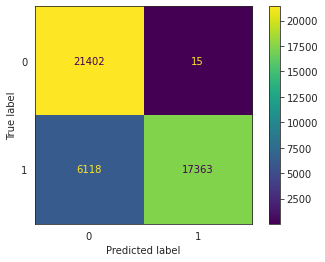

In [8]:
sns.set_style('white')
cm = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=df_news["is_fake"],
        y_pred=df_news["pred_is_fake"],
    )
)
cm.plot()

In [9]:
df_false_negatives = df_news[(df_news["is_fake"] == True) & (df_news["pred_is_fake"] == False) ]

In [10]:
display_titles(df_data=df_false_negatives, top_k=10)

Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Drunk Bragging Trump Staffer Started Russian Collusion Investigation
Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’
Pope Francis Just Called Out Donald Trump During His Christmas Speech
"Papa John’s Founder Retires, Figures Out Racism Is Bad For Business"
Bad News For Trump — Mitch McConnell Says No To Repealing Obamacare In 2018
"WATCH: Lindsey Graham Trashes Media For Portraying Trump As ‘Kooky,’ Forgets His Own Words"
Tone Deaf Trump: Congrats Rep. Scalise On Losing Weight After You Almost Died
The Internet Brutally Mocks Disney’s New Trump Robot At Hall Of Presidents
Mueller Spokesman Just F-cked Up Donald Trump’s Christmas


  0%|          | 0/1056 [00:00<?, ?it/s]

 Classification Report
-----------------------
              precision    recall  f1-score   support

       False       0.65      0.92      0.76       624
        True       0.72      0.29      0.41       432

    accuracy                           0.66      1056
   macro avg       0.69      0.61      0.59      1056
weighted avg       0.68      0.66      0.62      1056



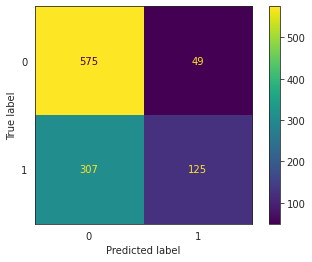

In [11]:
eval_rule(
    fake_file_path="../data/fakenewsnet/politifact_fake.csv",
    real_file_path="../data/fakenewsnet/politifact_real.csv",
)

  0%|          | 0/22140 [00:00<?, ?it/s]

 Classification Report
-----------------------
              precision    recall  f1-score   support

       False       0.76      0.96      0.85     16817
        True       0.32      0.05      0.09      5323

    accuracy                           0.75     22140
   macro avg       0.54      0.51      0.47     22140
weighted avg       0.66      0.75      0.67     22140



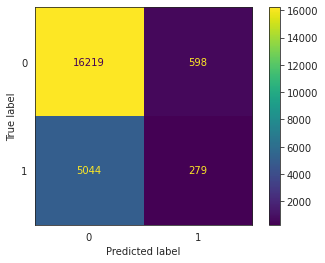

In [12]:
eval_rule(
    fake_file_path="../data/fakenewsnet/gossipcop_fake.csv",
    real_file_path="../data/fakenewsnet/gossipcop_real.csv",
)